In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# nbsafety vs nbgather slice result comparison

Author: shreyashankar

This notebook compares the sizes of the slices from nbgather and nbsafety. For each notebook (trace, session pair), we perform the following:

1. Filter out cells in the notebook that cannot be parsed by python's `ast`
2. Isolate the last _line_ of code in the notebook into its own cell
3. Compute dependencies (at the statement level) for the last line in the notebook (note that for nbsafety, we actually have to run the notebook)
4. For nbsafety, verify that the slice, when run, produce the same output as the notebook did
5. For nbgather, verify that the slice can run

Note that for steps 4 and 5, often the output cannot be reproduced (for example, when there is intentional randomness) or the slice cannot be run (for example, when the user forgot to import a library or my computer does not have that library installed or I cannot open a hardedcoded file path).%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [20]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## Read files into dataframes

Here is a dictionary of the dataframe we work with:

| Column      | Description |
| ----------- | ----------- |
| `key` | (trace, session) tuple |
| `nbsafety_line_size`      | number of lines in the slice generated by nbsafety       |
| `nbgather_line_size`   | number of lines in the slice generated by nbgather        |
| `exit_status` | exit code produced by a program that runs the nbgather slice (0 for success) |
| `nbsafety_slice_size` | number of cells in the slice generated by nbsafety |
| `nbsafety_reproduced` | boolean indicator whether nbsafety's slice, when run, produces the same output as the original notebook |

In [21]:
# Read nbsafety file
f = open("../stats.txt", "r+")
lines = f.readlines()[1:]
lines = [line[1:-2].split(",") for line in lines]
nbsafety_processed_trace_sessions = {
    (int(line[0].strip()), int(line[1].strip())): (int(line[-3].strip()), int(line[-2].strip()), bool(line[-1].strip()))
    for line in lines
}

In [22]:
# Read nbgather file
f = open("../nbgather_stats.txt", "r+")
lines = f.readlines()[1:]
lines = [line[1:-2].split(",") for line in lines]
nbgather_processed_trace_sessions = {
    (int(line[0].strip()), int(line[1].strip())): int(line[2].strip()) for line in lines
}

In [23]:
# Read nbgather successes

f = open("../nbgather_slice_runs.txt", "r+")
lines = f.readlines()[1:]
nbgather_slice_runs = {}

for line in lines:
    filename, status = line.strip().split(',')
    trace = int(filename.split('_')[0])
    session = int(filename.split('_')[1].split('.')[0])
    nbgather_slice_runs[(trace, session)] = int(status)

In [24]:
nbsafety_df = pd.DataFrame({"key": nbsafety_processed_trace_sessions.keys(), "nbsafety_line_size": nbsafety_processed_trace_sessions.values()})
nbgather_df = pd.DataFrame({"key": nbgather_processed_trace_sessions.keys(), "nbgather_line_size": nbgather_processed_trace_sessions.values()})

nbgather_run_df = pd.DataFrame({"key": nbgather_slice_runs.keys(), "exit_status": nbgather_slice_runs.values()})

In [25]:
full_df = nbsafety_df.merge(nbgather_df, on=['key'], how='inner').merge(nbgather_run_df, on=['key'], how='inner')
full_df[['nbsafety_slice_size', 'nbsafety_line_size', 'nbsafety_reproduced']] = pd.DataFrame(full_df['nbsafety_line_size'].to_list(), index=full_df.index)

In [30]:
# show dataframe

full_df

,key,nbsafety_line_size,nbgather_line_size,exit_status,nbsafety_slice_size,nbsafety_reproduced
0,"(9, 16)",1,1,0,1,True
1,"(9, 18)",2,5,0,2,True
2,"(9, 75)",1,2,1,1,True
3,"(9, 81)",2,2,0,2,True
4,"(9, 85)",1,1,0,1,True
...,...,...,...,...,...,...
369,"(851, 483)",1,1,0,1,True
370,"(851, 908)",2,23,1,2,True
371,"(851, 911)",1,18,1,1,True
372,"(851, 985)",1,17,1,1,True


## Subset dataframes based on various criteria

In [12]:
# Helpers

def plot_num_lines_histogram(df):
    bins = np.linspace(0, 200, 100)
    plt.hist(df['nbgather_line_size'], bins=bins, alpha=0.5, label='nbgather_num_lines')
    plt.hist(df['nbsafety_line_size'], bins=bins, alpha=0.5, label='nbsafety_num_lines')
    plt.legend()
    plt.title(f"Histogram of number of lines ({len(df)} sessions)")
    plt.show()

def plot_line_diff_histogram(df):
    df['diff'] = df['nbgather_line_size'] - df['nbsafety_line_size']
    df['diff'].hist(bins=100)
    plt.title("Histogram of (nbgather_num_lines - nbsafety_num_lines)")
    plt.show()

### No filtering

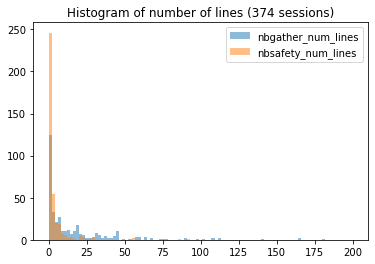

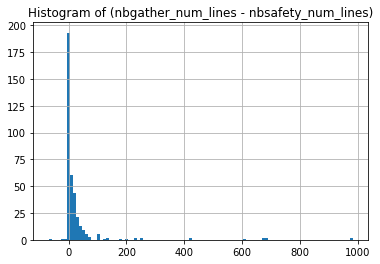

,nbsafety_line_size,nbgather_line_size,exit_status,nbsafety_slice_size,diff
count,374.000000,374.000000,374.000000,374.000000,374.000000
mean,4.112299,36.304813,0.724599,2.350267,32.192513
std,8.710919,115.435082,0.447315,2.297635,111.939257
min,1.000000,1.000000,0.000000,1.000000,-69.000000
25%,1.000000,2.000000,0.000000,1.000000,0.000000
50%,1.000000,7.000000,1.000000,1.000000,3.000000
75%,4.000000,22.000000,1.000000,3.000000,18.000000
max,91.000000,1013.000000,1.000000,18.000000,983.000000


In [15]:
plot_num_lines_histogram(full_df)
plot_line_diff_histogram(full_df)
full_df.describe()

### Select notebooks where nbgather's slices ran with exit status 0

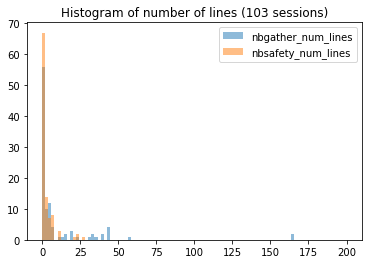

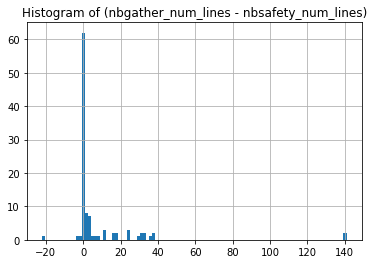

,nbsafety_line_size,nbgather_line_size,exit_status,nbsafety_slice_size,diff
count,103.000000,103.000000,103.0,103.000000,103.000000
mean,3.601942,10.902913,0.0,2.582524,7.300971
std,4.792436,25.031946,0.0,2.294598,21.539674
min,1.000000,1.000000,0.0,1.000000,-22.000000
25%,1.000000,1.000000,0.0,1.000000,0.000000
50%,2.000000,2.000000,0.0,2.000000,0.000000
75%,4.000000,6.000000,0.0,3.000000,3.500000
max,27.000000,165.000000,0.0,14.000000,141.000000


In [31]:
nbgather_ran_df = full_df[full_df['exit_status'] == 0].reset_index(drop=True)
plot_num_lines_histogram(nbgather_ran_df)
plot_line_diff_histogram(nbgather_ran_df)
nbgather_ran_df.describe()

### Select notebooks where num lines in slice > 1

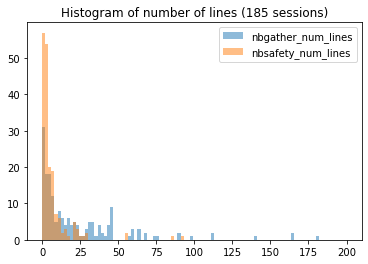

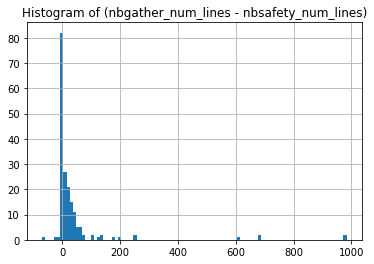

,nbsafety_line_size,nbgather_line_size,exit_status,nbsafety_slice_size,diff
count,185.000000,185.000000,185.000000,185.000000,185.000000
mean,7.291892,49.124324,0.632432,3.729730,41.832432
std,11.563210,139.316814,0.483451,2.629769,133.940038
min,2.000000,1.000000,0.000000,2.000000,-69.000000
25%,2.000000,4.000000,0.000000,2.000000,0.000000
50%,4.000000,13.000000,1.000000,3.000000,8.000000
75%,7.000000,37.000000,1.000000,4.000000,31.000000
max,91.000000,1013.000000,1.000000,18.000000,983.000000


In [32]:
large_slice_df = full_df[full_df['nbsafety_slice_size'] > 1].reset_index(drop=True)
plot_num_lines_histogram(large_slice_df)
plot_line_diff_histogram(large_slice_df)
large_slice_df.describe()

#df = df[df['exit_status'] == 0]